In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

# from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [48]:
df_train = pd.read_csv("DaniDatasets/preprocessed.csv", index_col=0)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [49]:
d = [i for i in df_train.columns if i != 'time' and i != 'event']

In [50]:
len(d)

8376

In [51]:
#cols_standardize = ['AGE', 'GENDER']
cols_standardize = d

cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [52]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [53]:
get_target = lambda df: (df['time'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [54]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [55]:
model = CoxPH(net, tt.optim.Adam)

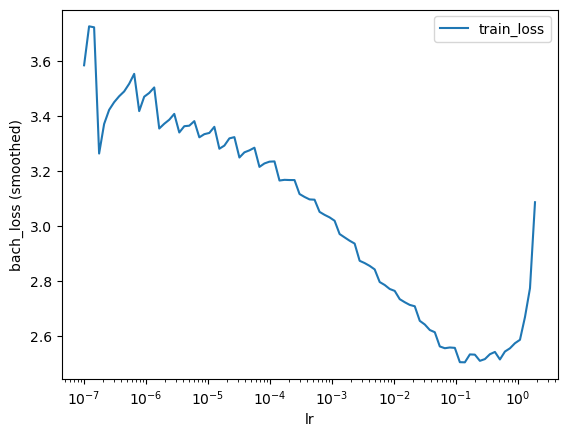

In [56]:
batch_size = 64
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [57]:
lrfinder.get_best_lr()

0.01384886371393861

In [58]:
model.optimizer.set_lr(0.01)

In [59]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

# %%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.4187,	val_loss: 3.6272
1:	[0s / 0s],		train_loss: 2.6790,	val_loss: 3.1595
2:	[0s / 0s],		train_loss: 2.6401,	val_loss: 3.1432
3:	[0s / 0s],		train_loss: 2.5309,	val_loss: 3.1499
4:	[0s / 0s],		train_loss: 2.2676,	val_loss: 3.1791
5:	[0s / 0s],		train_loss: 2.0310,	val_loss: 3.3875
6:	[0s / 0s],		train_loss: 2.0628,	val_loss: 3.7020
7:	[0s / 0s],		train_loss: 1.7501,	val_loss: 3.9236
8:	[0s / 0s],		train_loss: 1.7587,	val_loss: 4.3046
9:	[0s / 0s],		train_loss: 1.7094,	val_loss: 4.7228
10:	[0s / 1s],		train_loss: 1.7147,	val_loss: 4.5659
11:	[0s / 1s],		train_loss: 1.7659,	val_loss: 4.1421
12:	[0s / 1s],		train_loss: 1.5176,	val_loss: 4.2119


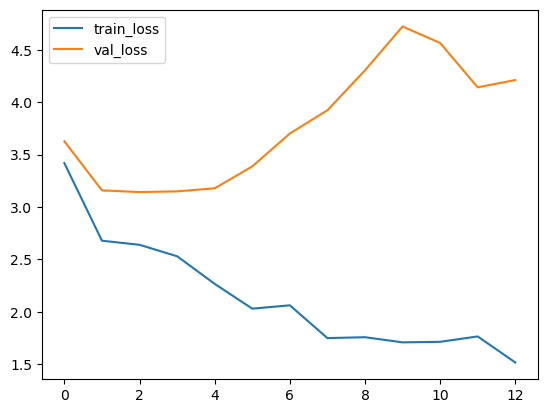

In [60]:
_ = log.plot()

In [61]:
model.partial_log_likelihood(*val).mean()

-3.143151

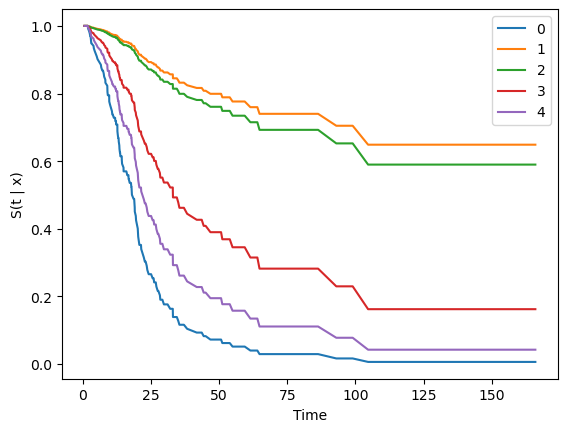

In [62]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [63]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [64]:
ev.concordance_td()

0.664396887159533

In [65]:
## 0.55 on all omics

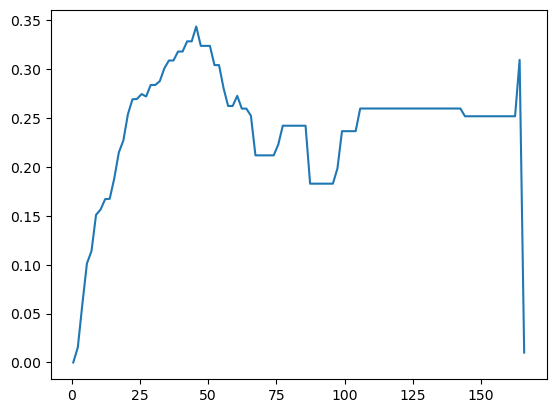

In [46]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()